# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

ModuleNotFoundError: No module named 'PIL'

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

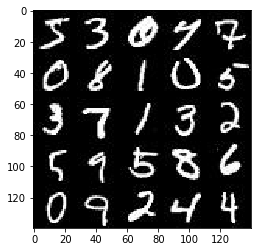

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

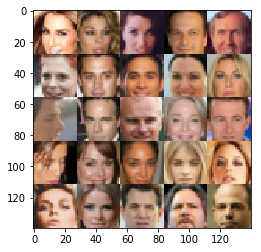

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


C:\Users\hlei\AppData\Local\Continuum\Anaconda3\envs\seq2seq\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),'real_input')
    z_input = tf.placeholder(tf.float32,(None,z_dim),'z_input')
    
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return real_input,z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator',reuse=reuse):
        
        alpha = 0.2
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(x1*alpha, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(x2*alpha, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides = 2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(x3*alpha, x3)
        
        flat = tf.reshape(relu3, (-1,4*4*256))
        logits = tf.layers.dense(flat,1)
        output = tf.sigmoid(logits)
        
        

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse = not is_train):
        
        alpha=0.2
        
        x1 = tf.layers.dense(z,7*7*512)
        x1 = tf.reshape(x1,(-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha*x1,x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha*x2,x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128 , 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha*x3,x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, True)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    print_every = 20
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps+=1
                # The values of the MNIST and CelebA dataset are in the range of -0.5 to 0.5
                batch_images = batch_images * 2
                 # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                 # Run optimizers 
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, 
                                               input_real: batch_images,
                                               lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:                   
                    show_generator_output(sess, 20, input_z, image_channels, data_image_mode)
                       
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/5... Discriminator Loss: 0.1567... Generator Loss: 6.5566
Epoch 1/5... Discriminator Loss: 0.1745... Generator Loss: 7.3712
Epoch 1/5... Discriminator Loss: 0.1621... Generator Loss: 2.9294
Epoch 1/5... Discriminator Loss: 0.7483... Generator Loss: 2.5049
Epoch 1/5... Discriminator Loss: 0.9486... Generator Loss: 1.4572


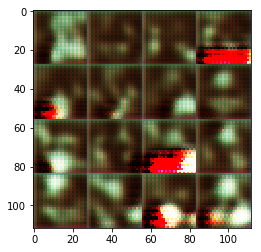

Epoch 1/5... Discriminator Loss: 0.8651... Generator Loss: 1.5339
Epoch 1/5... Discriminator Loss: 0.7368... Generator Loss: 1.4918
Epoch 1/5... Discriminator Loss: 1.2054... Generator Loss: 2.2373
Epoch 1/5... Discriminator Loss: 1.0764... Generator Loss: 2.2379
Epoch 1/5... Discriminator Loss: 1.1245... Generator Loss: 1.7908


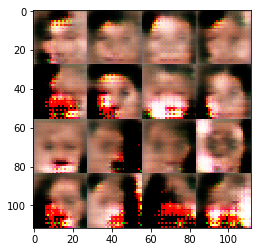

Epoch 1/5... Discriminator Loss: 0.9969... Generator Loss: 1.6991
Epoch 1/5... Discriminator Loss: 1.0372... Generator Loss: 1.5176
Epoch 1/5... Discriminator Loss: 1.2165... Generator Loss: 1.2546
Epoch 1/5... Discriminator Loss: 0.9525... Generator Loss: 1.2219
Epoch 1/5... Discriminator Loss: 1.1709... Generator Loss: 1.4685


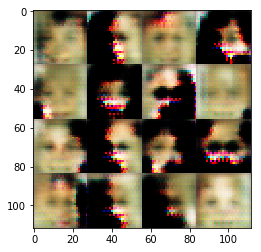

Epoch 1/5... Discriminator Loss: 0.8788... Generator Loss: 0.8951
Epoch 1/5... Discriminator Loss: 1.0884... Generator Loss: 1.0257
Epoch 1/5... Discriminator Loss: 0.9533... Generator Loss: 1.4522
Epoch 1/5... Discriminator Loss: 1.2705... Generator Loss: 0.7856
Epoch 1/5... Discriminator Loss: 0.8452... Generator Loss: 1.8362


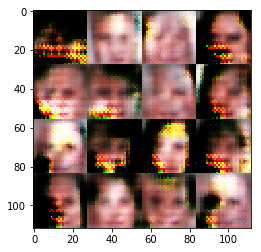

Epoch 1/5... Discriminator Loss: 1.2294... Generator Loss: 1.2574
Epoch 1/5... Discriminator Loss: 1.1385... Generator Loss: 1.2600
Epoch 1/5... Discriminator Loss: 0.9988... Generator Loss: 0.8968
Epoch 1/5... Discriminator Loss: 1.1330... Generator Loss: 1.1663
Epoch 1/5... Discriminator Loss: 1.1748... Generator Loss: 1.1160


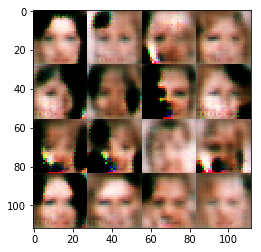

Epoch 1/5... Discriminator Loss: 1.1328... Generator Loss: 1.3146
Epoch 1/5... Discriminator Loss: 1.2099... Generator Loss: 1.7050
Epoch 1/5... Discriminator Loss: 1.0372... Generator Loss: 1.3025
Epoch 1/5... Discriminator Loss: 0.9469... Generator Loss: 1.2519
Epoch 1/5... Discriminator Loss: 1.2673... Generator Loss: 0.9381


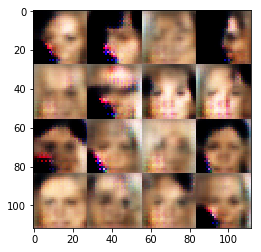

Epoch 1/5... Discriminator Loss: 1.2629... Generator Loss: 1.2066
Epoch 1/5... Discriminator Loss: 1.1255... Generator Loss: 1.1292
Epoch 1/5... Discriminator Loss: 1.1672... Generator Loss: 1.6489
Epoch 1/5... Discriminator Loss: 1.1077... Generator Loss: 1.0092
Epoch 1/5... Discriminator Loss: 1.3132... Generator Loss: 0.9227


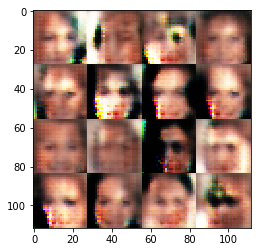

Epoch 1/5... Discriminator Loss: 1.3349... Generator Loss: 0.8499
Epoch 1/5... Discriminator Loss: 1.0918... Generator Loss: 1.0646
Epoch 1/5... Discriminator Loss: 1.1273... Generator Loss: 1.0433
Epoch 1/5... Discriminator Loss: 1.3547... Generator Loss: 1.1190
Epoch 1/5... Discriminator Loss: 1.2610... Generator Loss: 0.8371


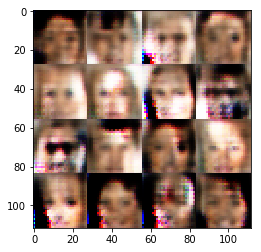

Epoch 1/5... Discriminator Loss: 1.0609... Generator Loss: 0.9405
Epoch 1/5... Discriminator Loss: 1.0565... Generator Loss: 0.9330
Epoch 1/5... Discriminator Loss: 1.0213... Generator Loss: 1.1253
Epoch 1/5... Discriminator Loss: 1.4206... Generator Loss: 1.1839
Epoch 1/5... Discriminator Loss: 1.5673... Generator Loss: 0.3387


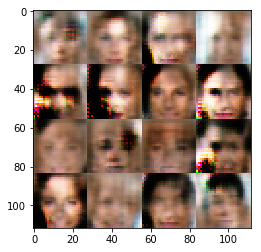

Epoch 1/5... Discriminator Loss: 1.2014... Generator Loss: 1.1726
Epoch 1/5... Discriminator Loss: 1.1617... Generator Loss: 0.8143
Epoch 1/5... Discriminator Loss: 1.3708... Generator Loss: 1.1843
Epoch 1/5... Discriminator Loss: 1.1069... Generator Loss: 0.8690
Epoch 1/5... Discriminator Loss: 1.1151... Generator Loss: 0.7449


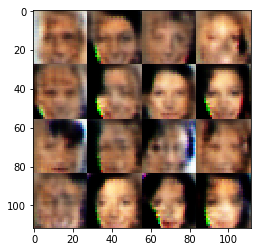

Epoch 1/5... Discriminator Loss: 1.2674... Generator Loss: 0.8318
Epoch 1/5... Discriminator Loss: 1.1505... Generator Loss: 0.7345
Epoch 1/5... Discriminator Loss: 1.3069... Generator Loss: 1.1941
Epoch 1/5... Discriminator Loss: 1.0813... Generator Loss: 0.8797
Epoch 1/5... Discriminator Loss: 1.1854... Generator Loss: 0.7995


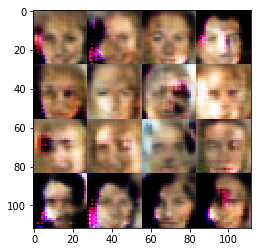

Epoch 1/5... Discriminator Loss: 1.1547... Generator Loss: 0.8748
Epoch 1/5... Discriminator Loss: 1.3145... Generator Loss: 0.7071
Epoch 1/5... Discriminator Loss: 1.5093... Generator Loss: 0.7361
Epoch 1/5... Discriminator Loss: 1.1927... Generator Loss: 0.8709
Epoch 1/5... Discriminator Loss: 1.5163... Generator Loss: 2.4102


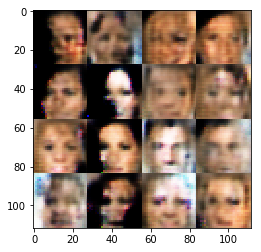

Epoch 1/5... Discriminator Loss: 1.3548... Generator Loss: 0.6905
Epoch 1/5... Discriminator Loss: 1.3906... Generator Loss: 0.6317
Epoch 1/5... Discriminator Loss: 1.1263... Generator Loss: 1.0964
Epoch 1/5... Discriminator Loss: 1.3424... Generator Loss: 0.6018
Epoch 1/5... Discriminator Loss: 1.2443... Generator Loss: 0.7286


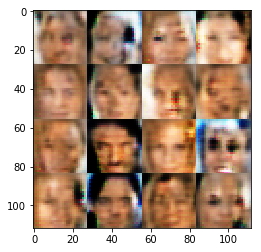

Epoch 1/5... Discriminator Loss: 1.3335... Generator Loss: 0.5310
Epoch 1/5... Discriminator Loss: 1.5506... Generator Loss: 1.0665
Epoch 1/5... Discriminator Loss: 1.2353... Generator Loss: 0.6697
Epoch 1/5... Discriminator Loss: 1.0136... Generator Loss: 0.9855
Epoch 1/5... Discriminator Loss: 1.1973... Generator Loss: 0.6659


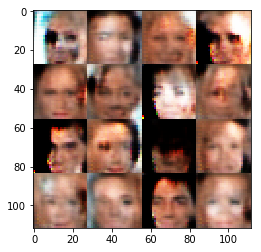

Epoch 1/5... Discriminator Loss: 1.2958... Generator Loss: 0.5758
Epoch 1/5... Discriminator Loss: 1.3185... Generator Loss: 1.0807
Epoch 1/5... Discriminator Loss: 1.2338... Generator Loss: 0.9202
Epoch 1/5... Discriminator Loss: 1.2524... Generator Loss: 0.9234
Epoch 1/5... Discriminator Loss: 1.3599... Generator Loss: 0.6534


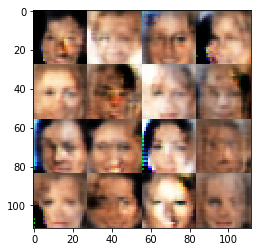

Epoch 1/5... Discriminator Loss: 1.3484... Generator Loss: 0.6550
Epoch 1/5... Discriminator Loss: 1.1437... Generator Loss: 1.0189
Epoch 1/5... Discriminator Loss: 1.1932... Generator Loss: 0.8611
Epoch 1/5... Discriminator Loss: 1.3506... Generator Loss: 0.6531
Epoch 2/5... Discriminator Loss: 1.4046... Generator Loss: 0.7089


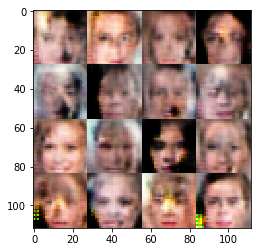

Epoch 2/5... Discriminator Loss: 1.3054... Generator Loss: 1.1961
Epoch 2/5... Discriminator Loss: 1.2504... Generator Loss: 0.6758
Epoch 2/5... Discriminator Loss: 1.3890... Generator Loss: 0.9733
Epoch 2/5... Discriminator Loss: 1.2792... Generator Loss: 0.8106
Epoch 2/5... Discriminator Loss: 1.3031... Generator Loss: 1.3595


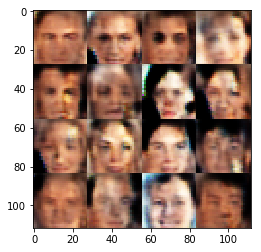

Epoch 2/5... Discriminator Loss: 1.2000... Generator Loss: 0.9618
Epoch 2/5... Discriminator Loss: 1.1901... Generator Loss: 0.9603
Epoch 2/5... Discriminator Loss: 1.2146... Generator Loss: 0.6978
Epoch 2/5... Discriminator Loss: 1.2399... Generator Loss: 0.6850
Epoch 2/5... Discriminator Loss: 1.2296... Generator Loss: 1.0231


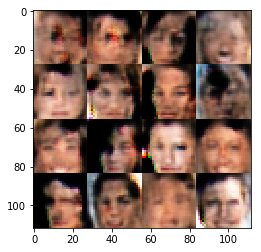

Epoch 2/5... Discriminator Loss: 1.1661... Generator Loss: 0.6714
Epoch 2/5... Discriminator Loss: 1.3150... Generator Loss: 0.6802
Epoch 2/5... Discriminator Loss: 1.1982... Generator Loss: 1.2215
Epoch 2/5... Discriminator Loss: 1.2839... Generator Loss: 0.7595
Epoch 2/5... Discriminator Loss: 1.6020... Generator Loss: 0.6581


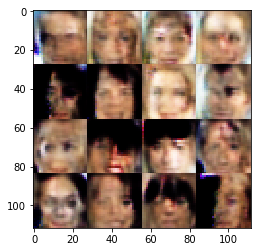

Epoch 2/5... Discriminator Loss: 1.1326... Generator Loss: 1.0550
Epoch 2/5... Discriminator Loss: 1.2863... Generator Loss: 0.7738
Epoch 2/5... Discriminator Loss: 1.2132... Generator Loss: 0.8274
Epoch 2/5... Discriminator Loss: 1.2175... Generator Loss: 1.1278
Epoch 2/5... Discriminator Loss: 1.2666... Generator Loss: 0.6316


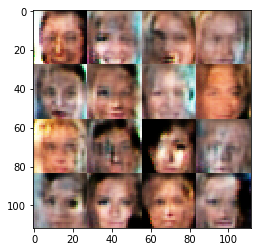

Epoch 2/5... Discriminator Loss: 1.1653... Generator Loss: 1.1118
Epoch 2/5... Discriminator Loss: 1.0984... Generator Loss: 1.1133
Epoch 2/5... Discriminator Loss: 1.1377... Generator Loss: 0.7940
Epoch 2/5... Discriminator Loss: 1.0473... Generator Loss: 1.0125
Epoch 2/5... Discriminator Loss: 1.3000... Generator Loss: 0.7641


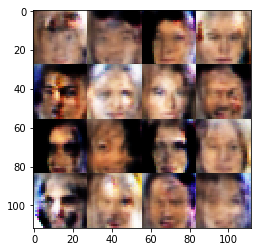

Epoch 2/5... Discriminator Loss: 1.2383... Generator Loss: 1.1282
Epoch 2/5... Discriminator Loss: 1.1517... Generator Loss: 0.7628
Epoch 2/5... Discriminator Loss: 1.3298... Generator Loss: 0.5273
Epoch 2/5... Discriminator Loss: 1.3336... Generator Loss: 0.7811
Epoch 2/5... Discriminator Loss: 1.2584... Generator Loss: 0.9406


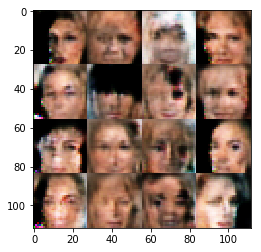

Epoch 2/5... Discriminator Loss: 1.3447... Generator Loss: 1.1523
Epoch 2/5... Discriminator Loss: 1.2444... Generator Loss: 1.0454
Epoch 2/5... Discriminator Loss: 1.2492... Generator Loss: 0.9005
Epoch 2/5... Discriminator Loss: 1.2025... Generator Loss: 0.6753
Epoch 2/5... Discriminator Loss: 1.4161... Generator Loss: 0.4946


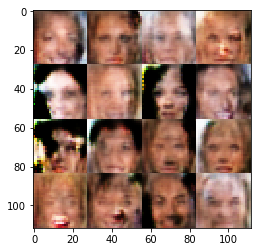

Epoch 2/5... Discriminator Loss: 1.2631... Generator Loss: 1.1838
Epoch 2/5... Discriminator Loss: 12.0573... Generator Loss: 0.0195
Epoch 2/5... Discriminator Loss: 6.7538... Generator Loss: 261.6231
Epoch 2/5... Discriminator Loss: 9.7269... Generator Loss: 88.6624
Epoch 2/5... Discriminator Loss: 4.4126... Generator Loss: 44.2402


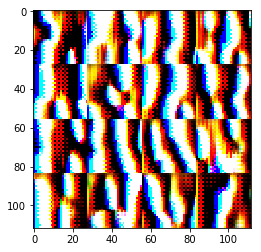

Epoch 2/5... Discriminator Loss: 2.5184... Generator Loss: 37.3541
Epoch 2/5... Discriminator Loss: 4.7023... Generator Loss: 30.1038
Epoch 2/5... Discriminator Loss: 1.9494... Generator Loss: 22.5867
Epoch 2/5... Discriminator Loss: 1.6089... Generator Loss: 12.5445
Epoch 2/5... Discriminator Loss: 0.8800... Generator Loss: 26.1388


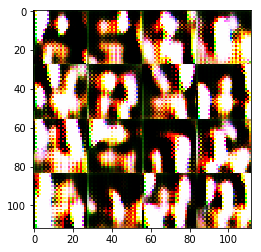

Epoch 2/5... Discriminator Loss: 0.9408... Generator Loss: 16.8238
Epoch 2/5... Discriminator Loss: 0.9021... Generator Loss: 19.3149
Epoch 2/5... Discriminator Loss: 0.4001... Generator Loss: 15.8018
Epoch 2/5... Discriminator Loss: 0.2651... Generator Loss: 12.9978
Epoch 2/5... Discriminator Loss: 0.4685... Generator Loss: 12.7540


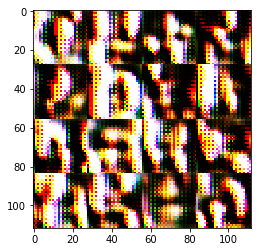

Epoch 2/5... Discriminator Loss: 0.2506... Generator Loss: 13.0520
Epoch 2/5... Discriminator Loss: 0.3338... Generator Loss: 8.6445
Epoch 2/5... Discriminator Loss: 0.6190... Generator Loss: 8.5236
Epoch 2/5... Discriminator Loss: 0.4970... Generator Loss: 12.2687
Epoch 2/5... Discriminator Loss: 0.8680... Generator Loss: 9.0313


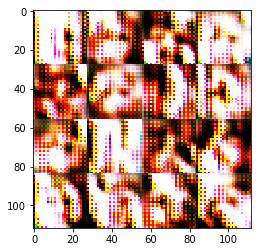

Epoch 2/5... Discriminator Loss: 0.6461... Generator Loss: 8.5966
Epoch 2/5... Discriminator Loss: 0.3321... Generator Loss: 8.8696
Epoch 2/5... Discriminator Loss: 0.4977... Generator Loss: 7.0901
Epoch 2/5... Discriminator Loss: 0.4859... Generator Loss: 11.0416
Epoch 2/5... Discriminator Loss: 0.5615... Generator Loss: 7.1725


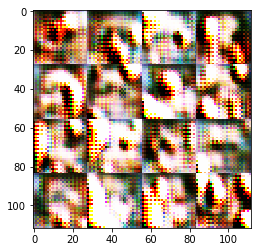

Epoch 2/5... Discriminator Loss: 0.8197... Generator Loss: 7.1269
Epoch 2/5... Discriminator Loss: 41.2438... Generator Loss: 232.2426
Epoch 2/5... Discriminator Loss: 1.8413... Generator Loss: 13.3675
Epoch 2/5... Discriminator Loss: 0.4352... Generator Loss: 11.3845
Epoch 2/5... Discriminator Loss: 0.1476... Generator Loss: 10.1451


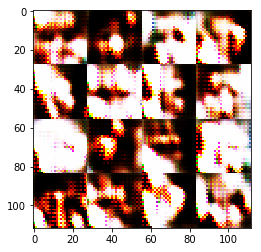

Epoch 2/5... Discriminator Loss: 0.2794... Generator Loss: 9.8572
Epoch 2/5... Discriminator Loss: 0.7480... Generator Loss: 6.9293
Epoch 2/5... Discriminator Loss: 0.3980... Generator Loss: 5.9727
Epoch 2/5... Discriminator Loss: 5.1797... Generator Loss: 19.7037
Epoch 2/5... Discriminator Loss: 0.4331... Generator Loss: 5.6954


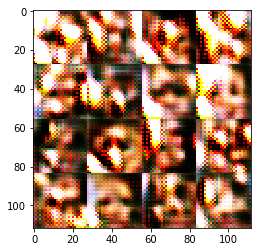

Epoch 2/5... Discriminator Loss: 4.5542... Generator Loss: 1.0278


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.